In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / "oc_mini"

# Add hcat package to path
sys.path.insert(0, str(BASE_DIR / "cat-hcat" / "hcat"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load tree and metadata
tree_path = DATA_DIR / "clustering" / "hierarchical" / "oc_mini_paris.json"
metadata_path = DATA_DIR / "metadata" / "oc_mini_node_metadata.csv"

with open(tree_path, 'r') as f:
    tree_data = json.load(f)

metadata_df = pd.read_csv(metadata_path)

print(f"Tree data loaded: {tree_data['num_nodes']} nodes")
print(f"Metadata loaded: {len(metadata_df)} entries")
metadata_df.head()

Tree data loaded: 14384 nodes
Metadata loaded: 14442 entries


,id,doi,title,abstract
0,128,10.1101/2021.05.10.443415,Improved protein contact prediction using dime...,AbstractDeep residual learning has shown great...
1,163,10.1101/2021.05.07.443114,Following the Trail of One Million Genomes: Fo...,AbstractSevere acute respiratory syndrome coro...
2,200,10.1101/2021.05.11.443555,Mechanism of molnupiravir-induced SARS-CoV-2 m...,Molnupiravir is an orally available antiviral ...
3,941,10.3390/ijms20020449,Bactericidal and Cytotoxic Properties of Silve...,Silver nanoparticles (AgNPs) can be synthesize...
4,1141,10.3390/ijms20040865,Silver Nanoparticles: Synthesis and Applicatio...,"Over the past few decades, metal nanoparticles..."


In [3]:
from train import train_model

# Train model with adaptive margin triplet loss
finetuned_model, tokenizer, history = train_model(
    tree_json_path=str(tree_path),
    metadata_csv_path=str(metadata_path),
    output_dir=str(BASE_DIR / "cat-hcat" / "models" / "finetuned_adaptive_margin"),
    model_name='allenai/scibert_scivocab_uncased',
    device=str(device),
    batch_size=16,
    epochs=3,
    lr=1e-5,
    base_margin=0.5,        # Base triplet margin
    distance_scale=0.05,     # KEY: Scale margin by tree distance
    samples_per_leaf=3,     # ~43K triplets for 14K leaves
    pooling='cls',
    sampling_strategy='hierarchical'
)

Using device: cuda

Loading tree from /home/vikramr2/oc_mini/clustering/hierarchical/oc_mini_paris.json...
  Leaves: 14384
  Total nodes: 28767
  Max depth: 25

Loading metadata from /home/vikramr2/oc_mini/metadata/oc_mini_node_metadata.csv...
  Entries: 14442

Loading model: allenai/scibert_scivocab_uncased...

Creating dataset...


Generating triplets: 100%|██████████| 14384/14384 [32:19<00:00,  7.42it/s]


  Generated 43152 triplets
  Train: 38836 | Val: 4316

Loss: AdaptiveMarginTripletLoss
  Base margin: 0.5
  Distance scale: 0.05

Starting training for 3 epochs

Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [37:48<00:00,  1.07it/s, loss=0.0000]


  Train loss: 0.1371


Evaluating: 100%|██████████| 270/270 [01:30<00:00,  3.00it/s]


  Val loss: 0.0088
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin...

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [37:47<00:00,  1.07it/s, loss=0.0000]


  Train loss: 0.0132


Evaluating: 100%|██████████| 270/270 [01:29<00:00,  3.01it/s]


  Val loss: 0.0080
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin...

Epoch 3/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [37:48<00:00,  1.07it/s, loss=0.0047]


  Train loss: 0.0079


Evaluating: 100%|██████████| 270/270 [01:29<00:00,  3.01it/s]


  Val loss: 0.0063
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin...

Training complete!
  Best val loss: 0.0063
  Model saved to: /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin


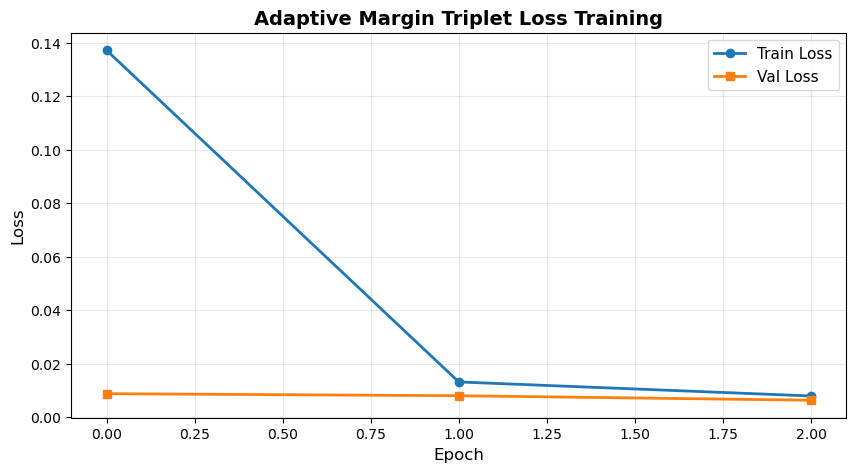


Final train loss: 0.0079
Final val loss: 0.0063


In [4]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], marker='o', label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], marker='s', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Adaptive Margin Triplet Loss Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")


In [5]:
from notebook_utils import compute_embeddings

# Load the BEST saved model (not the final epoch model)
output_dir = BASE_DIR / "cat-hcat" / "models" / "finetuned_adaptive_margin"

print("Loading best saved model...")
best_tokenizer = AutoTokenizer.from_pretrained(str(output_dir))
best_model = AutoModel.from_pretrained(str(output_dir)).to(device)
best_model.eval()

print(f"✓ Loaded best model from: {output_dir}")

# Compute embeddings for all nodes using BEST model
print("\nComputing embeddings with best model...")
embeddings_dict = compute_embeddings(
    best_model,  # Use BEST saved model
    best_tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Computed embeddings for {len(embeddings_dict)} nodes")

Loading best saved model...
✓ Loaded best model from: /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin

Computing embeddings with best model...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
✓ Computed embeddings for 14442 nodes


In [6]:
from notebook_utils import create_test_split

all_node_ids = list(embeddings_dict.keys())
test_nodes = create_test_split(all_node_ids, test_ratio=0.1, seed=42)

print(f"Test set: {len(test_nodes)} nodes ({len(test_nodes)/len(all_node_ids)*100:.1f}%)")

Test set: 1444 nodes (10.0%)



NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0343
    Recall@5: 0.0145
    Hit Rate@5: 0.1445
  K=10:
    Precision@10: 0.0286
    Recall@10: 0.0233
    Hit Rate@10: 0.2120
  K=20:
    Precision@20: 0.0220
    Recall@20: 0.0355
    Hit Rate@20: 0.2953
  K=50:
    Precision@50: 0.0163
    Recall@50: 0.0654
    Hit Rate@50: 0.4510
  K=100:
    Precision@100: 0.0128
    Recall@100: 0.0999
    Hit Rate@100: 0.5719

AUC Metrics:
  AUC-ROC: 0.8031
  AUC-PR: 0.2886



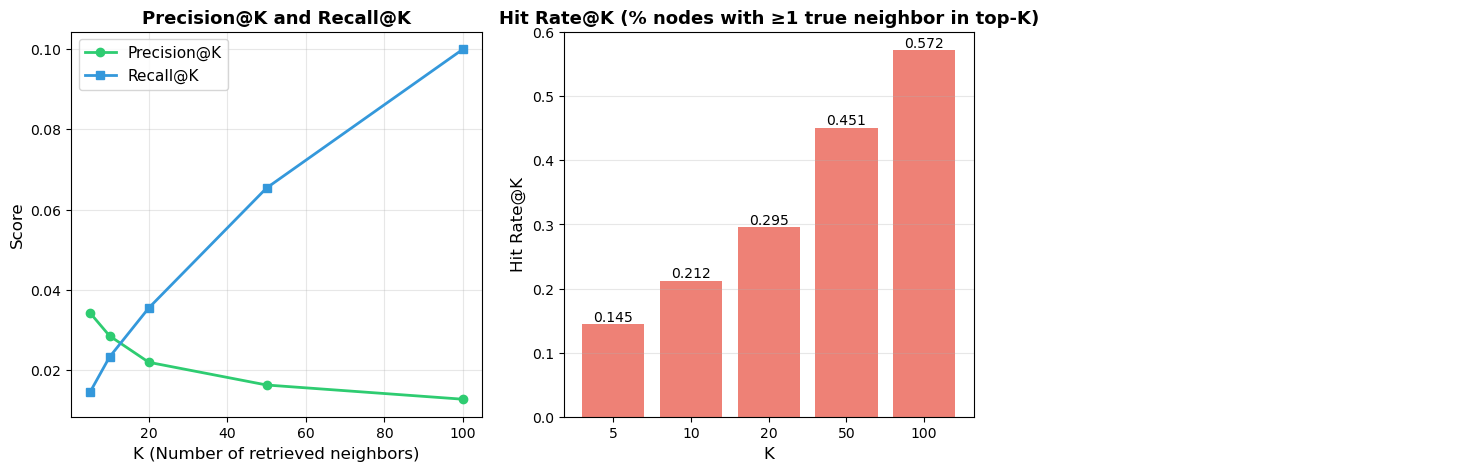

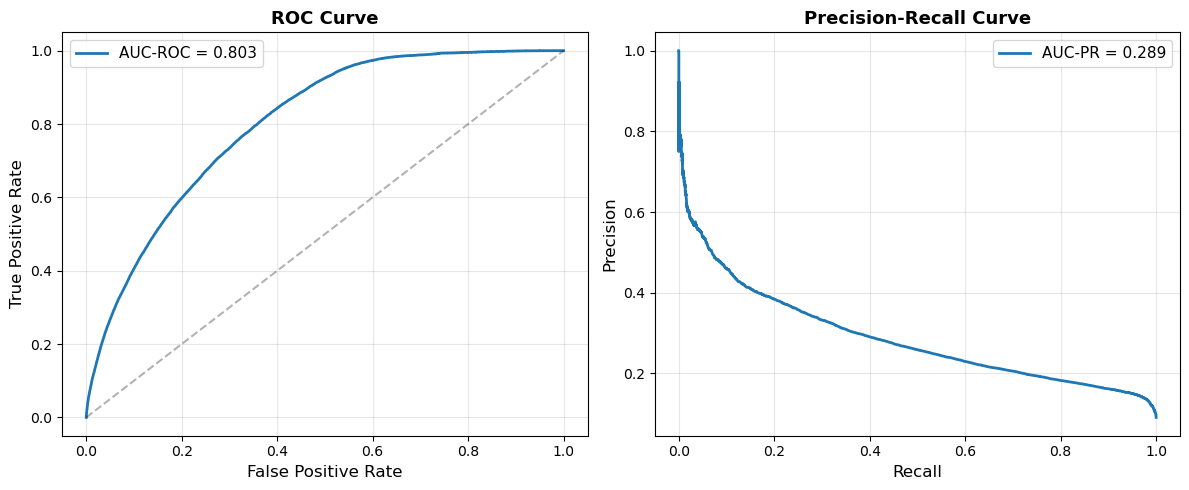

<Figure size 640x480 with 0 Axes>

In [7]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat" / "experiments"))

from network_link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results
)

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Evaluate fine-tuned model
results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=embeddings_dict,
    test_nodes=test_nodes,
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

# Visualize
plot_link_prediction_results(results['topk'], results['auc'])

In [8]:
# Load baseline SciBERT (not fine-tuned)
print("Loading baseline model...")
baseline_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased").to(device)

# Compute baseline embeddings
print("Computing baseline embeddings...")
baseline_embeddings = compute_embeddings(
    baseline_model,
    tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Baseline embeddings: {len(baseline_embeddings)} nodes")

Loading baseline model...
Computing baseline embeddings...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
✓ Baseline embeddings: 14442 nodes


In [9]:
# Evaluate baseline
print("Evaluating baseline...")
baseline_results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=baseline_embeddings,
    test_nodes=test_nodes,
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

Evaluating baseline...

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0257
    Recall@5: 0.0109
    Hit Rate@5: 0.1119
  K=10:
    Precision@10: 0.0202
    Recall@10: 0.0158
    Hit Rate@10: 0.1564
  K=20:
    Precision@20: 0.0161
    Recall@20: 0.0262
    Hit Rate@20: 0.2314
  K=50:
    Precision@50: 0.0121
    Recall@50: 0.0479
    Hit Rate@50: 0.3746
  K=100:
    Precision@100: 0.0093
    Recall@100: 0.0774
    Hit Rate@100: 0.4920

AUC Metrics:
  AUC-ROC: 0.6563
  AUC-PR: 0.2092




PRECISION@K COMPARISON: Baseline vs Fine-tuned (Adaptive Margin Loss)
  K  Baseline Precision  Fine-tuned Precision  Improvement  Improvement %
  5            0.025712              0.034329     0.008617      33.513514
 10            0.020153              0.028562     0.008409      41.724138
 20            0.016088              0.021994     0.005907      36.717063
 50            0.012106              0.016345     0.004239      35.017222
100            0.009347              0.012808     0.003461      37.026022

AUC METRICS
Baseline AUC-ROC:    0.6563
Fine-tuned AUC-ROC:  0.8031
Improvement:         0.1469 (22.4%)

Baseline AUC-PR:     0.2092
Fine-tuned AUC-PR:   0.2886
Improvement:         0.0794 (37.9%)


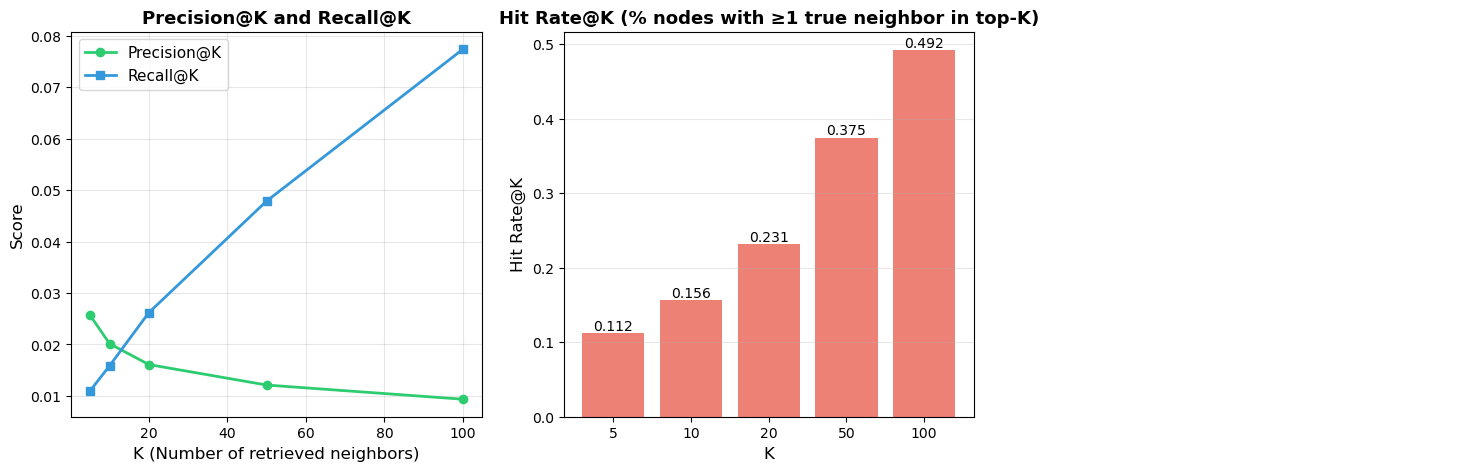

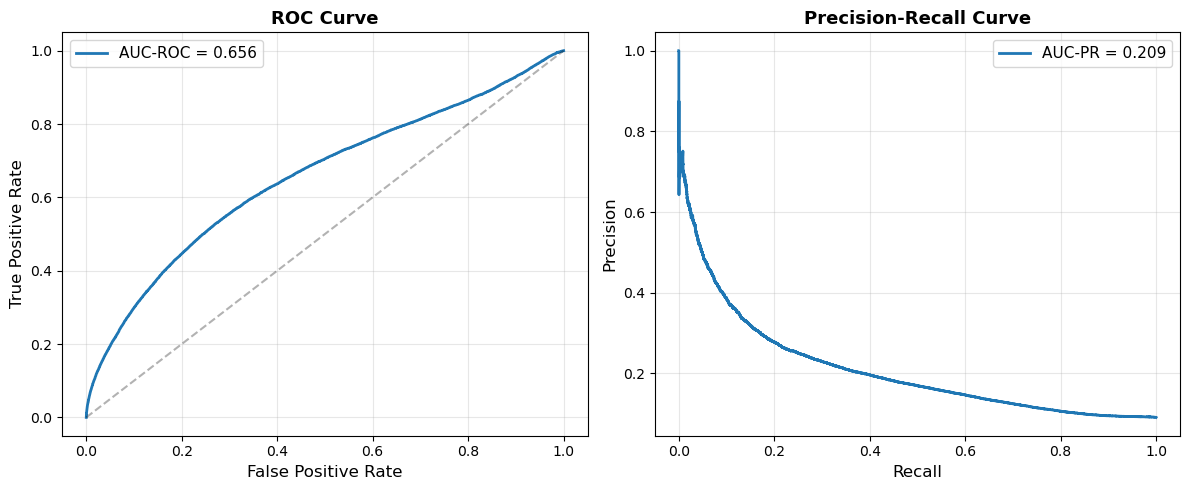

<Figure size 640x480 with 0 Axes>

In [10]:
# Create comparison table
k_values = [5, 10, 20, 50, 100]
comparison_data = []

for k in k_values:
    baseline_prec = baseline_results['topk']['summary'][k]['precision@k']
    finetuned_prec = results['topk']['summary'][k]['precision@k']

    comparison_data.append({
        'K': k,
        'Baseline Precision': baseline_prec,
        'Fine-tuned Precision': finetuned_prec,
        'Improvement': finetuned_prec - baseline_prec,
        'Improvement %': ((finetuned_prec - baseline_prec) / baseline_prec) * 100
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("PRECISION@K COMPARISON: Baseline vs Fine-tuned (Adaptive Margin Loss)")
print("="*80)
print(comparison_df.to_string(index=False))

# AUC comparison
print("\n" + "="*80)
print("AUC METRICS")
print("="*80)
print(f"Baseline AUC-ROC:    {baseline_results['auc']['auc_roc']:.4f}")
print(f"Fine-tuned AUC-ROC:  {results['auc']['auc_roc']:.4f}")
print(f"Improvement:         {results['auc']['auc_roc'] - baseline_results['auc']['auc_roc']:.4f} " +
      f"({((results['auc']['auc_roc'] - baseline_results['auc']['auc_roc'])/baseline_results['auc']['auc_roc'])*100:.1f}%)")
print()
print(f"Baseline AUC-PR:     {baseline_results['auc']['auc_pr']:.4f}")
print(f"Fine-tuned AUC-PR:   {results['auc']['auc_pr']:.4f}")
print(f"Improvement:         {results['auc']['auc_pr'] - baseline_results['auc']['auc_pr']:.4f} " +
      f"({((results['auc']['auc_pr'] - baseline_results['auc']['auc_pr'])/baseline_results['auc']['auc_pr'])*100:.1f}%)")

# Visualize
plot_link_prediction_results(baseline_results['topk'], baseline_results['auc'])

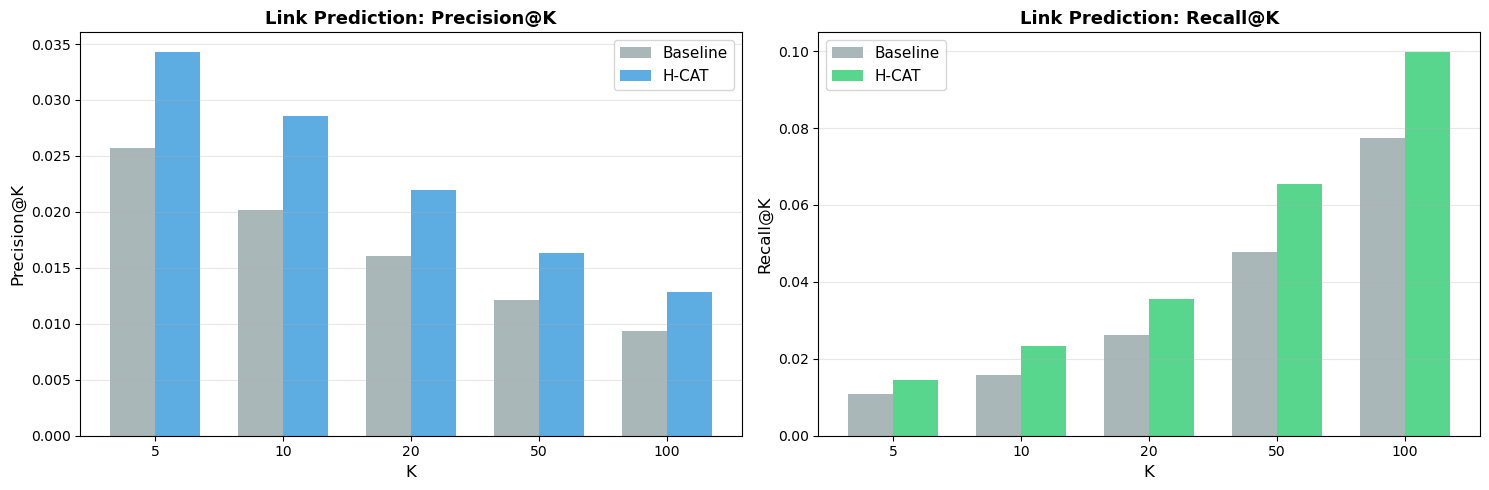

In [11]:
# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Precision@K
ax = axes[0]
x = np.arange(len(k_values))
width = 0.35

baseline_prec = [baseline_results['topk']['summary'][k]['precision@k'] for k in k_values]
finetuned_prec = [results['topk']['summary'][k]['precision@k'] for k in k_values]

bars1 = ax.bar(x - width/2, baseline_prec, width, label='Baseline', alpha=0.8, color='#95a5a6')
bars2 = ax.bar(x + width/2, finetuned_prec, width, label='H-CAT', alpha=0.8, color='#3498db')

ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Precision@K', fontsize=12)
ax.set_title('Link Prediction: Precision@K', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(k_values)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)

# Recall@K
ax = axes[1]
baseline_rec = [baseline_results['topk']['summary'][k]['recall@k'] for k in k_values]
finetuned_rec = [results['topk']['summary'][k]['recall@k'] for k in k_values]

bars1 = ax.bar(x - width/2, baseline_rec, width, label='Baseline', alpha=0.8, color='#95a5a6')
bars2 = ax.bar(x + width/2, finetuned_rec, width, label='H-CAT', alpha=0.8, color='#2ecc71')

ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Recall@K', fontsize=12)
ax.set_title('Link Prediction: Recall@K', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(k_values)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
import pickle

# Save comparison
results_dir = BASE_DIR / "cat-hcat" / "hcat" / "experiments" / "results"
results_dir.mkdir(exist_ok=True, parents=True)

comparison_df.to_csv(results_dir / "link_prediction_comparison.csv", index=False)

with open(results_dir / "evaluation_results.pkl", 'wb') as f:
    pickle.dump({
        'fine_tuned': results,
        'baseline': baseline_results,
        'test_nodes': test_nodes,
        'history': history
    }, f)

print(f"✓ Results saved to: {results_dir}")

✓ Results saved to: /home/vikramr2/cat-hcat/hcat/experiments/results
